# 6. PyTorch Transfer Learning

> Note: This notebook uses torchvision's new [multi-weight support API (available in torchvision v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/)

## What is transfer learning?

**Transfer learning** allows us to get the patterns (also called weights) that another model learned from another problem and use them in our problem

For instance, we can bring patterns of a computer vision model that has been trained from a dataset like [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them in our FoodVision model

Or get patterns from a [language model](https://developers.google.com/machine-learning/glossary#masked-language-model) and use them to classify text samples

The premise is to find a well-performing existing model and use it to our own problem

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-example-overview.png)

## Why use transfer learning?

1. Leverage an existing model proven to work on problems similar to our own
2. Leverage a working model which has **already learned** patterns on similar data to ours. This often results in achieving **great results with less custom data**

![image1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-for-foodvision-mini%20.png)

## Where to find pretrained models

- PyTorch domain libraries
- HuggingFace Hub
- `timm` (PyTorch Image Models) library
- Paperswithcode

## 0. Getting setup

Start by importing/downloading the required modules

We'll use some of the Python scripts from Chapter 5 - PyTorch Going Modular to save some time

We'll also get [`torchinfo`](https://github.com/TylerYep/torchinfo) for visual representation of our model later



In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
# try:
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

In [ ]:
# Loading other libraries
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] couldn't find torchinfo, installing it")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts, downloading them from GitHub")
    !git clone https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
    !mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/going_modular .
    !rm -rf PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
    from going_modular import get_data, data_setup, engine # to load all scripts "*" doesn't work

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

We'll use the same dataset to compare our model's performance

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
zipfile_path = data_path / "pizza_steak_sushi.zip"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} directory doesn't exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download data
    with open(zipfile_path, "wb") as f:
        request = requests.get("https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data")
        f.write(request.content)
    
    # Unzip data
    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        print("Unzipping data")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(zipfile_path)

data/pizza_steak_sushi directory exists


In [ ]:
# Setup dir
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

We can use `data_setup.py` script from `going_modular` directory

But we'll use pretrained model from `torchvision.models` and there's a specific transform we need to process our images first

### 2.1 Creating a transform for torchvision.models (manual creation)

> Note: As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model.**

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in torchvision.models, the documentation stated:

>All pre-trained models expect input images normalized in the same way, i.e. >mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are >expected to be at least 224.
>
>The images have to be loaded in to a range of [0, 1] and then normalized using >mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
>
>You can use the following transform to normalize:
>
>```
>normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                 std=[0.229, 0.224, 0.225])
>```

The good news is, we can achieve the above transformations with a combination of:

| Transform <br> number | Transform required | Code to perform transform | 
|--|--|--|
| 1 |	Mini-batches of size [batch_size, <br> 3, height, width]  where height <br> and width are at least 224x224^. | torchvision.transforms.Resize() to resize <br> images into [3, 224, 224]^ and <br> `torch.utils.data.DataLoader()` to create <br> batches of images. 
| 2 |	Values between 0 & 1. |	torchvision.transforms.ToTensor()
| 3 |	A mean of [0.485, 0.456, <br> 0.406] (values across each <br> color channel). |	torchvision.transforms.Normalize(mean=...) <br> to adjust the mean of our images. 
| 4 | A standard deviation of [0.229, <br> 0.224, 0.225] (values across <br> each colour channel). | torchvision.transforms.Normalize(std=...) <br> to adjust the standard deviation of our images. |

>Note: ^some pretrained models from torchvision.models are in different sizes to [3, 224, 224], for example, some might take them in [3, 240, 240]. For specific input image sizes, see the documentation.

>Question: *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
>These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
>We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of torchvision.transforms to perform the above steps.

In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                      # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(),                              # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])     # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

That's the **manually created series of transforms** to preprocess our images

Now we can create training and testing DataLoader using create_dataloaders function from `data_setup.py` script

We'll set `batch_size=32` and transform images using `transform=manual_transforms`

> **Note:** I've included this manual creation of transforms in this notebook because you may come across resources that use this style. It's also important to note that because these transforms are manually created, they're also infinitely customizable. So if you wanted to included data augmentation techniques in your transforms pipeline, you could.

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32)               # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f94469cf880>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model.**

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:

```
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,

- `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many differnt model architecture options in `torchvision.models`)
- `DEFAULT` means the best available weights (the best performance in ImageNet)
    - **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms assosciated with our `weights`, we can use the `transforms()` method.

This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,   # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32)               # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f9446acdf90>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Now we know for a fact that our models weren't performing as expected, thus we'll be using **transfer learning**

The idea of transfer learning is to **take an already well-performing model on a problem space similar to yours and then customize it to your use case**

Our problem is computer vision related, so we can use pretrained models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification)

### 3.1 Which pretrained model should you use?

It depends on the problem/device working with

Generally, higher the number in the model name (e.g. `efficientnet_b0()` < `efficientnet_b1()` < `efficientnet_b7()` means *better performance* but a *larger* model

Better performance is great, but **some better performing models are too big for some devices**

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as The Bitter Lesson states, you'd likely take the biggest, most compute hungry model you can.

Understanding this performance vs. speed vs. size tradeoff will come with time and practice.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment, experiment, experiment and see what works for your problem.

### 3.2 Setting up a pretrained model

We are going to use `torchvision.models.efficientnet_b0()`

The architecture is from the paper [*EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks*](https://arxiv.org/abs/1905.11946)

![image2](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png)



In [ ]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device)    # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT                # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# model                                                                     # uncomment to output (it's very long)

Print the model and we get something similar to the following:

![image3](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png)

Our `efficientnet_b0` comes in three main parts:

1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images")
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

To use `summary()` method from `torchinfo` we'll pass in:
- `model`: model we'd like to get a summary of
- `input_size`: shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`
    - **Note**: Many modern models can handle input images of varying sizes thanks to `torch.nn.AdaptiveAvgPool2d()`, this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to `summary()` for your models.
- `col_names`: various information columns we'd like to see about our model
- `col_width`: how wide the columns should be for the summary
- `row_settings`: what features to show in a row


In [ ]:
# Print a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"],                                         # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"], # uncomment for actual output
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

![image4](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png)

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, **TinyVGG had 8,083 parameters vs. 5,288,548 parameters for `efficientnet_b0`, an increase of ~654x!**

Will this mean better performance?

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes:
- freeze some base layers of a pretrained model (typically the features section)
- then adjust the output layers (also called head/classifier layers) to suit your needs.

![image5](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png)

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0 model`

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze layers/parameters using `for` loop in sections (e.g. `features`) or full model and setting the attribute `requires_grad=False`. Then PyTorch doesn't track gradient updates and these parameters won't be changed by our optimizer during training

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Now it's time to adjust the output layer or the `classifier` portion of our pretrained model to our needs

Since ImageNet has 1000 classes, pretrained model has `out_features=1000`, which needs to be changed to `out_features=3` to match our dataset (pizza, steak, sushi)

We change the `classifier` portion of our model by creating a new series of layers

Current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using `torch.nn.Dropout(p=0.2, inplace=True)`

> **Note:** Dropout layers randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).

And we'll keep `in_features=1280` for our Linear output layer but we'll change the `out_features` value to the length of our `class_names (len(['pizza', 'steak', 'sushi']) = 3)`

Our new `classifier` layer should be on the same device as our model.

In [ ]:
# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=1280,
                    out_features=3, # same number of output units as our number of classes
                    bias=True)
).to(device)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

![image6](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png)

Few changes noted in the following:
- **Trainable column:** You'll see that many of the base layers (the ones in the `features` portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. Unless we change this, these layers won't be updated during furture training.
- **Output shape of `classifier`:** The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the `features` portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
- **Less trainable parameters:** Previously there was 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note:** The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## 4. Train model

Since we've got a pretrained model that's semi-frozen and has a customized `classifier`, let's train a model

We'll start by creating a loss function and an optimizer

In [ ]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Now we'll use `train()` function from `engine.py` script for 5 epochs

> **Note:** We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=5,
                       device=device)

# End the timer
end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0880 | train_acc: 0.3906 | test_loss: 0.8962 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.8714 | train_acc: 0.7695 | test_loss: 0.7829 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.7731 | train_acc: 0.7891 | test_loss: 0.7393 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7152 | train_acc: 0.7578 | test_loss: 0.6336 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6181 | train_acc: 0.7930 | test_loss: 0.6247 | test_acc: 0.8665
[INFO] Total training time: 22.4071 seconds


Result is significantly different as it doubles our previous model results to 87% and taking approx. 20 seconds

## 5. Evaluate model by plotting loss curves

Let's plot loss curves to see the performance over time by using the `plot_loss_curves()` function from chapter 4, which is stored in `helper_functions.py` script

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] helper_functions.py doesn't exist, downloading")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

[INFO] helper_functions.py doesn't exist, downloading


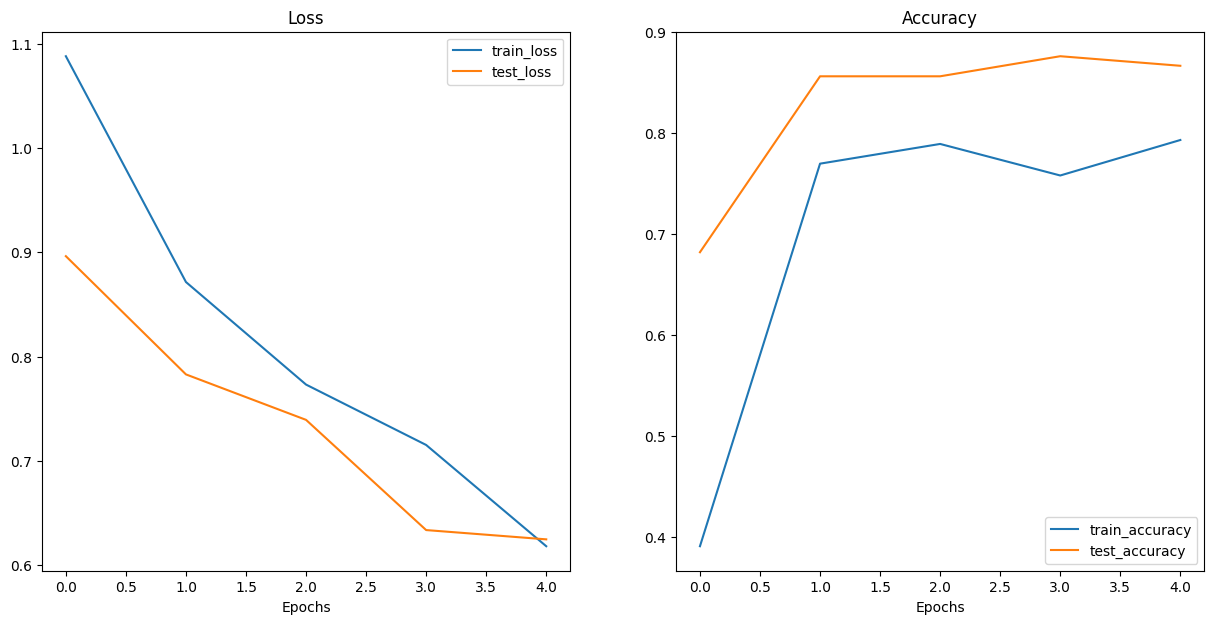

In [ ]:
# Plot the loss curves of our model
plot_loss_curves(results)

The plot shows the power of **transfer learning**

> **Question:** Looking at the loss curves, does our model look like it's overfitting or underfitting? Or perhaps neither? Hint: Check out notebook 04. PyTorch Custom Datasets part 8. What should an ideal loss curve look like? for ideas.

## 6. Make predictions on images from the test set

Time to make a prediction on an image and we need to make sure that hte image is in the *same* format as the images our model was trained on

It means we'll need to ensure our images have:
- **Same shape**: If our images are different shapes to what our model was trained on, we'll get shape errors.
- **Same datatype**: If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
- **Same device**: If our images are on a different device to our model, we'll get device errors.
- **Same transformations**: If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:
1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open an image with `PIL.Image.open()`
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

> **Note:** This is a similar function to 04. PyTorch Custom Datasets section 11.3's `pred_and_plot_image()` with a few tweaked steps.

In [ ]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform, and a target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device,
                        mean: List[int] = [0.485, 0.456, 0.406],
                        std: List[int] = [0.229, 0.224, 0.225]):
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform=transform
    else:
        image_transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])
    
    ## Predict on image ##

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires same samples in [batch_size, color_channels, height, width])
        transformed_img = image_transform(img).unsqueeze(dim=0).to(device)

        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_img)

        # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # 9. Convert prediction probabilities -> prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        # 10. Plot image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.4f}")
        plt.axis("off");

Now that we've created a function, let's make a prediction on a few random images from the test set

We can get a list of all the test image paths using `list(Path(test_dir).glob("*/*.jpg"))`, the stars in the `glob()` method say "any file matching this pattern", in other words, any file ending in `.jpg` (all of our images).

And then we can randomly sample a number of these using Python's `random.sample(populuation, k)` where `population` is the sequence to sample and `k` is the number of samples to retrieve.

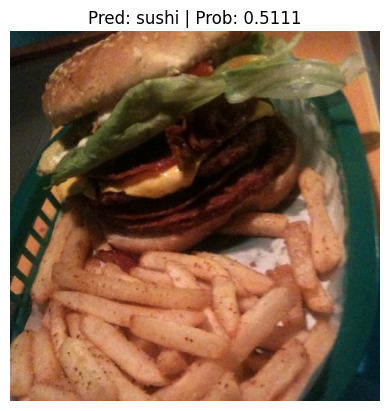

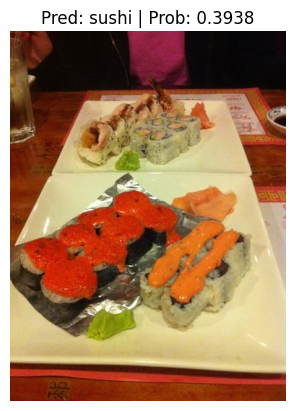

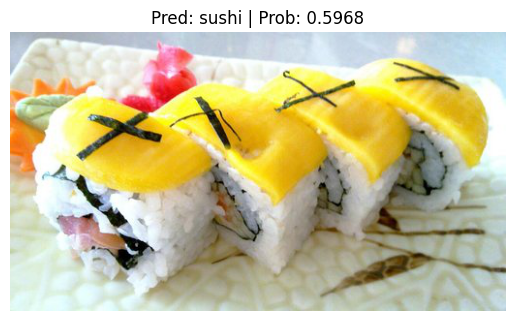

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))                 # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list,     # go through all of the test image paths
                                       k=num_images_to_plot)                # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(),                   # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

Let's check whether the model performs well on our custom image as well

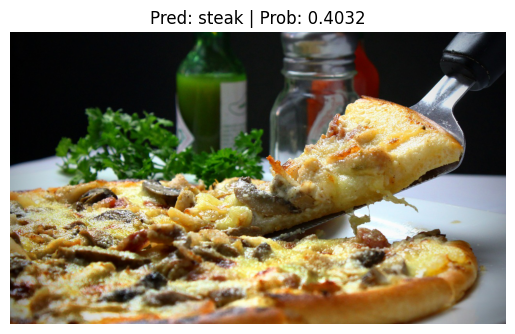

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza_image.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://cdn.pixabay.com/photo/2014/04/22/02/56/pizza-329523_1280.jpg")
        print(f"Downloading {custom_image_path}")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Hmm... not good enough to predict correctly on custom data yet

Improving the model can certainly change the result of the prediction, so give it a go